In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
def evalf(x):  
  #Input: x is a numpy array of size 2
  assert type(x) is np.ndarray and len(x) == 2 #do not allow arbitrary arguments

  return 512*(x[1]-x[0]**2)**2+(4-x[0])**2

In [4]:
def evalg(x):
  #Input: x is a numpy array of size 2
  assert type(x) is np.ndarray and len(x) == 2 #do not allow arbitrary arguments 
  
  return np.array([-2048*x[0]*(x[1]-x[0]**2)-2*(4-x[0]), 1024*(x[1]-x[0]**2)])

In [5]:
#method to find Hessian matrix:
def evalh(x): 
  assert type(x) is np.ndarray 
  assert len(x) == 2

  return np.array([[6144*(x[0])**2-2048*x[1]+2, -2048*x[0]],[-2048*x[0],1024]])

#method to find the condition number of any square matrix:
def find_condition_number(A):
  assert type(A) is np.ndarray
  assert A.shape[0] == A.shape[1]

  return np.linalg.cond(A)

**Q 1**

Hessian matrix of the given function is,
$$H=\begin{bmatrix}
6144x_1x_1^2-2048x_2+2 & -2048x_1 \\
-2048x_1 & 1024
\end{bmatrix}$$

So, we can take,
$$\mathbf{D^k}=\begin{bmatrix}
\frac{1}{6144x_1x_1^2-2048x_2+2} & 0 \\
0 & \frac{1}{1024}
\end{bmatrix}$$ \\
$\mathbf{D^k}$ is a diagonal matrix with diagonal entries as the reciprocal of 2nd order derivative of function wrt to $x_1$ and $x_2$ respectively.

In [6]:
#The method defines a way to construct D_k matrix used in scaling the gradient in the modified gradient descent scheme
def compute_D_k(x):
  assert type(x) is np.ndarray
  assert len(x) == 2
  H=evalh(x)
  return np.array([[1/H[0][0], 0],[0, 1/H[1][1]]])

In [7]:
#Complete the module to compute the steplength by using the closed-form expression
def compute_steplength_backtracking(x, gradf, alpha_start, rho, gamma): #add appropriate arguments to the function 
  assert type(x) is np.ndarray and len(gradf) == 2 
  assert type(gradf) is np.ndarray and len(gradf) == 2 
  assert type(alpha_start) is float and alpha_start>=0. 
  assert type(rho) is float and rho>=0.
  assert type(gamma) is float and gamma>=0. 
  
  alpha = alpha_start
  pk=-gradf
  while evalf(x+alpha*pk)>evalf(x)+gamma*alpha*np.linalg.multi_dot([gradf,pk]):
    alpha=rho*alpha
  
  return alpha

In [8]:
def compute_steplength_backtracking_scaled_direction(x, gradf, direction, alpha_start, rho, gamma): #add appropriate arguments to the function 
  assert type(x) is np.ndarray and len(gradf) == 2 
  assert type(gradf) is np.ndarray and len(gradf) == 2 
  assert type(direction) is np.ndarray and len(direction) == 2 
  assert type(alpha_start) is float and alpha_start>=0. 
  assert type(rho) is float and rho>=0.
  assert type(gamma) is float and gamma>=0. 
  
  alpha = alpha_start
  while evalf(x+alpha*direction)>evalf(x)+gamma*alpha*np.linalg.multi_dot([gradf,direction]):
    alpha=rho*alpha

  return alpha

In [9]:
#line search type 
BACKTRACKING_LINE_SEARCH = 1
BACKTRACKING_LINE_SEARCH_SCALING = 2

In [10]:
#complete the code for gradient descent to find the minimizer
def find_minimizer_gd(start_x, tol, line_search_type, *args):
  #Input: start_x is a numpy array of size 2, tol denotes the tolerance and is a positive float value
  assert type(start_x) is np.ndarray and len(start_x) == 2 #do not allow arbitrary arguments 
  assert type(tol) is float and tol>=0 
  
  cond_no_wo_scaling=[]
  x = start_x
  g_x = evalg(x)

  #initialization for backtracking line search
  if(line_search_type == BACKTRACKING_LINE_SEARCH):
    alpha_start = args[0]
    rho = args[1]
    gamma = args[2]

  k = 0

  while (np.linalg.norm(g_x) > tol): #continue as long as the norm of gradient is not close to zero upto a tolerance tol
    cond_no_wo_scaling.append(find_condition_number(evalh(x)))
    if line_search_type == BACKTRACKING_LINE_SEARCH:
      step_length = compute_steplength_backtracking(x,g_x, alpha_start,rho, gamma) #call the new function you wrote to compute the steplength
    else:  
      raise ValueError('Line search type unknown. Please check!')
    
    #implement the gradient descent steps here   
    x = np.subtract(x, np.multiply(step_length,g_x)) #update x = x - step_length*g_x
    k += 1 #increment iteration
    g_x = evalg(x) #compute gradient at new point

  return x, evalf(x),k,cond_no_wo_scaling

In [11]:
#complete the code for gradient descent with scaling to find the minimizer

def find_minimizer_gdscaling(x, tol, line_search_type,*args):
  #Input: start_x is a numpy array of size 2, tol denotes the tolerance and is a positive float value
  assert type(x) is np.ndarray and len(x) == 2 #do not allow arbitrary arguments 
  assert type(tol) is float and tol>=0 

  g_x = evalg(x)
  #D_k = compute_D_k(x)
  
  #initialization for backtracking line search
  if(line_search_type == BACKTRACKING_LINE_SEARCH_SCALING):
    alpha_start = args[0]
    rho = args[1]
    gamma = args[2]

  k = 0
  while (np.linalg.norm(g_x) > tol):
    D_k = compute_D_k(x)
    direction = -np.matmul(D_k, g_x)
    if line_search_type == BACKTRACKING_LINE_SEARCH_SCALING:
      step_length = compute_steplength_backtracking_scaled_direction(x, g_x, direction, alpha_start, rho, gamma)
    else:  
      raise ValueError('Line search type unknown. Please check!')

    #implement the gradient descent steps here   
    x = np.add(x, np.multiply(step_length,direction)) #update x = x + step_length*direction
    k += 1 #increment iteration
    g_x = evalg(x) #compute gradient at new point
  return x, evalf(x), k

In [12]:
my_start_x = np.array([8.,8.])
my_tol= 1e-5

In [13]:
#check gradient descent with backtracking line search 
alpha_start = 1.
rho = 0.5
gamma = 0.5

opt_x2,opt_f2,iter2,cond_no2=find_minimizer_gd(my_start_x,my_tol,BACKTRACKING_LINE_SEARCH,alpha_start,rho,gamma)
print('Gradient Descent algorithm(without scaling) with BACKTRACKING LINE SEARCH:')
print('\nMinimizer: ',opt_x2)
print('Minimum Obj fn Value: ',opt_f2)
print('No. of iterations taken: ', iter2)

Gradient Descent algorithm(without scaling) with BACKTRACKING LINE SEARCH:

Minimizer:  [ 3.99995978 15.99967826]
Minimum Obj fn Value:  1.6173741774296086e-09
No. of iterations taken:  902339


In [14]:
#check gradient descent with scaling and backtracking line search 
alpha_start = 1.
rho = 0.5
gamma = 0.5

opt_x3,opt_f3,iter3=find_minimizer_gdscaling(my_start_x,my_tol,BACKTRACKING_LINE_SEARCH_SCALING, alpha_start,rho,gamma)
print('Gradient Descent algorithm(with scaling) with BACKTRACKING LINE SEARCH:')
print('Minimizer: ',opt_x3)
print('Minimum Obj fn Value: ',opt_f3)
print('No. of iterations taken: ', iter3)

Gradient Descent algorithm(with scaling) with BACKTRACKING LINE SEARCH:
Minimizer:  [ 4.00000993 16.0000794 ]
Minimum Obj fn Value:  9.850897480037126e-11
No. of iterations taken:  904703


Both the methods are taking almost same number of iterations. It means that the scaling factor which we are using is not very effective. So, now we will use the scaling factor obtained by the Newton's Method.

**Q 3**

Here, the matrix $\mathbf{Q}$ whose condition number needs to be analyzed in the
new gradient scheme with scaling with $\mathbf{D}^k = (\nabla^2f(x^k))^{-1}$ is taken as $(\mathbf{D}^{\frac{1}{2}})^T H(f)\mathbf{D}^{\frac{1}{2}}$, where $H(f)$ is the Hessian of the given function $f$ under consideration.  \
So, for different iterations (in particular for $k^{\text{th}}$ iteration) we have $\mathbf{Q} = (\mathbf{(D^k)}^{\frac{1}{2}})^T H^k\mathbf{(D^k)}^{\frac{1}{2}} $ where $H^k=∇^2f(x^k).$

**Q 4**

In [15]:
def compute_D_k_newton(x):
  assert type(x) is np.ndarray
  assert len(x) == 2

  A=evalh(x)
  return np.linalg.inv(A)

In [22]:
import scipy
from scipy.linalg import sqrtm

In [16]:
#complete the code for gradient descent with scaling to find the minimizer
def find_minimizer_gdscaling_newton(x, tol, line_search_type,*args):
  #Input: start_x is a numpy array of size 2, tol denotes the tolerance and is a positive float value
  assert type(x) is np.ndarray and len(x) == 2 #do not allow arbitrary arguments 
  assert type(tol) is float and tol>=0 

  g_x = evalg(x)
  cond_no_with_scaling=[]
  
  #initialization for backtracking line search
  if(line_search_type == BACKTRACKING_LINE_SEARCH_SCALING):
    alpha_start = args[0]
    rho = args[1]
    gamma = args[2]

  k = 0
  while (np.linalg.norm(g_x) > tol):
    D_k = compute_D_k_newton(x)
    M=scipy.linalg.sqrtm(D_k)
    Q=np.matmul((np.matmul(np.matrix.transpose(M),evalh(x))),M)
    cond_no_with_scaling.append(find_condition_number(Q))
    direction = -np.matmul(D_k, g_x)
    if line_search_type == BACKTRACKING_LINE_SEARCH_SCALING:
      step_length = compute_steplength_backtracking_scaled_direction(x, g_x, direction, alpha_start, rho, gamma)
    else:  
      raise ValueError('Line search type unknown. Please check!')

    #implement the gradient descent steps here   
    x = np.add(x, np.multiply(step_length,direction)) #update x = x + step_length*direction
    k += 1 #increment iteration
    g_x = evalg(x) #compute gradient at new point
  return x, evalf(x), k, cond_no_with_scaling

In [17]:
my_start_x = np.array([8.,8.])
my_tol= 1e-5

In [20]:
#gradient descent algorithm (without scaling) with backtracking line search
#is done in Q 1 and list used below is used from there

print('For Gradient descent method(without scaling) with BACKTRACKING LINE SEARCH')
print()
for i in range(iter2):
  print('Condition number at iteration number '+str(i+1)+' is: ',cond_no2[i])

print()
print('Gradient Descent algorithm(without scaling) with BACKTRACKING LINE SEARCH:')
print('\nMinimizer: ',opt_x2)
print('Minimum Obj fn Value: ',opt_f2)
print('No. of iterations taken: ', iter2)

Streaming output truncated to the last 5000 lines.
Condition number at iteration number 897346 is:  2163212.283263653
Condition number at iteration number 897347 is:  2163189.0186012588
Condition number at iteration number 897348 is:  2163212.2870154586
Condition number at iteration number 897349 is:  2163189.0095708296
Condition number at iteration number 897350 is:  2163212.2907331963
Condition number at iteration number 897351 is:  2163189.0005380544
Condition number at iteration number 897352 is:  2163212.2944564237
Condition number at iteration number 897353 is:  2163188.9917433592
Condition number at iteration number 897354 is:  2163212.298224827
Condition number at iteration number 897355 is:  2163188.982705521
Condition number at iteration number 897356 is:  2163212.301967123
Condition number at iteration number 897357 is:  2163188.9736893433
Condition number at iteration number 897358 is:  2163212.305691026
Condition number at iteration number 897359 is:  2163188.964879647
Con

In [23]:
#check gradient descent with scaling and backtracking line search 
alpha_start = 1.
rho = 0.5
gamma = 0.5

opt_x1,opt_f1,iter1,cond_no1=find_minimizer_gdscaling_newton(my_start_x,my_tol,BACKTRACKING_LINE_SEARCH_SCALING, alpha_start,rho,gamma)
print('Gradient Descent algorithm(with NEWTON scaling) with BACKTRACKING LINE SEARCH:')
print('\nMinimizer: ',opt_x1)
print('Minimum Obj fn Value: ',opt_f1)
print('No. of iterations taken: ', iter1)
print()
for i in range(iter1):
  print('Condition number at iteration number '+str(i+1)+' is: ',cond_no1[i])

Gradient Descent algorithm(with NEWTON scaling) with BACKTRACKING LINE SEARCH:

Minimizer:  [ 4. 16.]
Minimum Obj fn Value:  2.356430075812841e-25
No. of iterations taken:  48

Condition number at iteration number 1 is:  1.0000000000000113
Condition number at iteration number 2 is:  1.0000000021417927
Condition number at iteration number 3 is:  1.000000000351985
Condition number at iteration number 4 is:  1.0000000000484224
Condition number at iteration number 5 is:  1.0000000001075267
Condition number at iteration number 6 is:  1.0000000000696554
Condition number at iteration number 7 is:  1.000000000070728
Condition number at iteration number 8 is:  1.0000000000475953
Condition number at iteration number 9 is:  1.000000000105539
Condition number at iteration number 10 is:  1.0000000000196416
Condition number at iteration number 11 is:  1.0000000000732865
Condition number at iteration number 12 is:  1.0000000001698197
Condition number at iteration number 13 is:  1.0000000000735774
Con

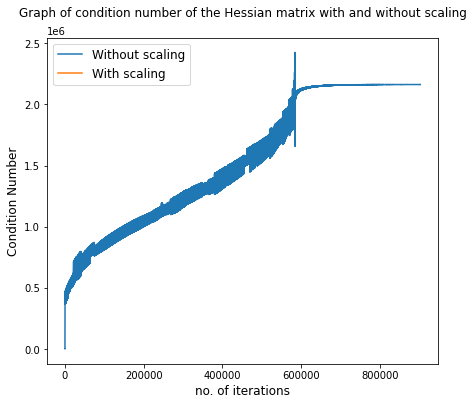

In [24]:
plt.figure(figsize=(7,6))
plt.plot(cond_no2,label=r'$ $')
plt.plot(cond_no1,label= r'$ $') 
plt.title('Graph of condition number of the Hessian matrix with and without scaling\n',fontsize=12)
plt.xlabel(r'no. of iterations',fontsize=12)
plt.ylabel(r'Condition Number',fontsize=12)
plt.legend(["Without scaling", "With scaling"],fontsize=12)
plt.show()

Here, only blue curve is visible and not the orange curve because the cond no. in case of without scaling is of order 1e6 and in case of with scaling is approx 1 also no. of iterations is very less (=48) in case of with scaling, which are very very less.

So, we will plot for with scaling seperately.

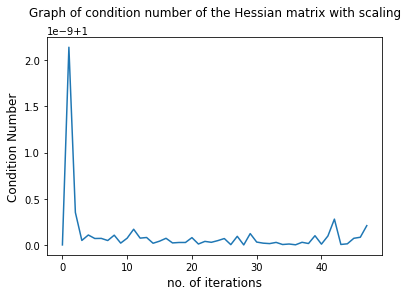

In [25]:
plt.plot(cond_no1,label= r'$ $')
plt.title('Graph of condition number of the Hessian matrix with scaling\n',fontsize=12)
plt.xlabel(r'no. of iterations',fontsize=12)
plt.ylabel(r'Condition Number',fontsize=12)

plt.show()

So, at the begining (at lower no. of iteration) the condition no. is large but it is less for the greater iteration numbers.